In [19]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import os
import torch
import torch.nn as nn
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from nltk.corpus import words

import sys
sys.path.append('./../../')
from models.rnn.rnn import RNN, RNNDataset
from models.ocr.ocr import OCRModel, OCRDataset

## RNN

In [20]:
def generate_bit_count_data(num_samples=100000, max_len=16):
    data, labels = [], []
    for _ in range(num_samples):
        length = np.random.randint(1, max_len + 1)
        sequence = np.random.randint(0, 2, length)
        label = np.sum(sequence)
        data.append(sequence)
        labels.append(label)
    return data, labels

In [21]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for sequences, labels, lengths in data_loader:
            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(), labels.squeeze(-1))
            total_loss += loss.item() * sequences.size(0)
    return total_loss / len(data_loader.dataset)

In [22]:
data, labels = generate_bit_count_data()
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))

train_data, val_data, test_data = data[:train_size], data[train_size:train_size + val_size], data[train_size + val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

train_dataset = RNNDataset(train_data, train_labels)
val_dataset = RNNDataset(val_data, val_labels)
test_dataset = RNNDataset(test_data, test_labels)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [23]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        train_progress = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
        
        for sequences, labels, lengths in train_progress:
            sequences, labels, lengths = sequences.to(device), labels.to(device), lengths.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs.squeeze(), labels.squeeze(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * sequences.size(0)
            train_progress.set_postfix(loss=loss.item())
        
        train_loss = total_train_loss / len(train_loader.dataset)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train MAE: {train_loss:.4f}, Validation MAE: {val_loss:.4f}")


In [24]:
model = RNN(input_size=1, hidden_size=32, num_layers=1)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10

In [25]:
def random_baseline_MAE(data_loader):
    loss = 0
    total = 0
    for sequences, labels, lengths in data_loader:
        for i in range(len(sequences)):
            cur_pred = np.random.randint(0, lengths[i].item() + 1)
            loss += np.abs(cur_pred - labels[i].item())
            total += 1
    return loss / total

In [26]:
print(f"Random Baseline MAE: {random_baseline_MAE(val_loader)}")

Random Baseline MAE: 2.5217


In [27]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Epoch [1/10]:   0%|          | 0/1250 [00:00<?, ?it/s]

Epoch [1/10]: 100%|██████████| 1250/1250 [01:02<00:00, 19.99it/s, loss=0.0973]


Epoch [1/10], Train MAE: 0.5786, Validation MAE: 0.0996


Epoch [2/10]: 100%|██████████| 1250/1250 [01:02<00:00, 19.92it/s, loss=0.109] 


Epoch [2/10], Train MAE: 0.1214, Validation MAE: 0.0891


Epoch [3/10]: 100%|██████████| 1250/1250 [00:50<00:00, 24.81it/s, loss=0.0339]


Epoch [3/10], Train MAE: 0.0987, Validation MAE: 0.0737


Epoch [4/10]: 100%|██████████| 1250/1250 [00:50<00:00, 24.81it/s, loss=0.155] 


Epoch [4/10], Train MAE: 0.0838, Validation MAE: 0.3148


Epoch [5/10]: 100%|██████████| 1250/1250 [00:49<00:00, 25.03it/s, loss=0.0279]


Epoch [5/10], Train MAE: 0.0793, Validation MAE: 0.0340


Epoch [6/10]: 100%|██████████| 1250/1250 [00:50<00:00, 24.98it/s, loss=0.0408]


Epoch [6/10], Train MAE: 0.0741, Validation MAE: 0.0304


Epoch [7/10]: 100%|██████████| 1250/1250 [00:48<00:00, 25.61it/s, loss=0.0313]


Epoch [7/10], Train MAE: 0.0671, Validation MAE: 0.0615


Epoch [8/10]: 100%|██████████| 1250/1250 [00:49<00:00, 25.42it/s, loss=0.033] 


Epoch [8/10], Train MAE: 0.0588, Validation MAE: 0.0352


Epoch [9/10]: 100%|██████████| 1250/1250 [00:49<00:00, 25.13it/s, loss=0.0957]


Epoch [9/10], Train MAE: 0.0634, Validation MAE: 0.1521


Epoch [10/10]: 100%|██████████| 1250/1250 [00:49<00:00, 25.15it/s, loss=0.0638]


Epoch [10/10], Train MAE: 0.0581, Validation MAE: 0.0322


In [28]:
test_loss = evaluate(model, test_loader, criterion, device)
print(f"Test MAE: {test_loss:.4f}")

Test MAE: 0.0318


In [29]:
def generate_out_of_distribution_data(start_len=1, end_len=32, samples_per_length=1000):
    data, labels = [], []
    for length in range(start_len, end_len + 1):
        for _ in range(samples_per_length):
            sequence = np.random.randint(0, 2, length)
            label = np.sum(sequence)
            data.append(sequence)
            labels.append(label)
    return data, labels

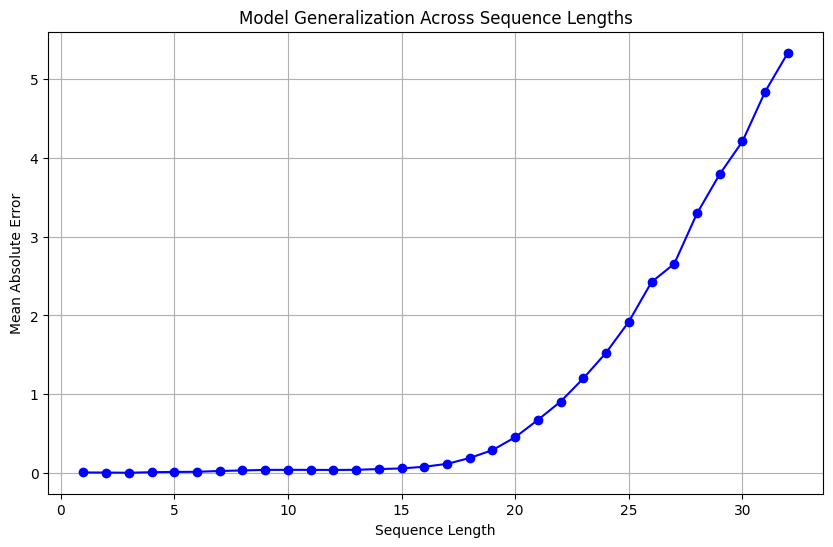

In [30]:
gen_data, gen_labels = generate_out_of_distribution_data()
lengths = list(range(1, 33))
mae_per_length = []

for length in lengths:
    length_data = []
    length_labels = []
    for seq, label in zip(gen_data, gen_labels):
        if len(seq) == length:
            length_data.append(seq)
            length_labels.append(label)
    
    length_dataset = RNNDataset(length_data, length_labels)
    length_loader = DataLoader(length_dataset, batch_size=batch_size, shuffle=False)
    mae = evaluate(model, length_loader, criterion, device)
    mae_per_length.append(mae)

plt.figure(figsize=(10, 6))
plt.plot(lengths, mae_per_length, marker='o', color='b')
plt.title('Model Generalization Across Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.savefig('./figures/RNN_generalization.png')
plt.show()

## OCR

In [31]:
def generate_word_images(word_list, image_dir, image_size=(256, 64)):
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
    for word in tqdm(word_list, desc="Generating Images"):
        img = Image.new('L', image_size, color=255)
        draw = ImageDraw.Draw(img)
        font = ImageFont.load_default()
        font_size = 24
        font = ImageFont.truetype("arial.ttf", font_size)
        bbox = draw.textbbox((0, 0), word, font=font)
        x = (image_size[0] - (bbox[2] - bbox[0])) // 2
        y = (image_size[1] - (bbox[3] - bbox[1])) // 2
        draw.text((x, y), word, font=font, fill=0)
        img.save(os.path.join(image_dir, f"{word}.png")) 

image_dir = "./../../data/external/word_images"
# word_list = words.words()
# word_list = list(set(word_list))
# word_list = word_list[:100000]
# generate_word_images(word_list, image_dir)

In [32]:
def create_image_label_lists(image_dir):
    image_paths = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            if ('-' in filename) or ('_' in filename):
                continue
            label = os.path.splitext(filename)[0]
            image_paths.append(os.path.join(image_dir, filename))
            labels.append(label)
    return image_paths, labels

In [33]:
image_paths, labels = create_image_label_lists(image_dir)
max_word_length = max(len(label) for label in labels)
print(f"Max Word Length: {max_word_length}")

image_paths_temp, labels_temp = np.array(image_paths), np.array(labels)
idx = np.random.permutation(len(image_paths_temp))
image_paths, labels = image_paths_temp[idx].tolist(), labels_temp[idx].tolist()

train_size = int(0.8 * len(image_paths))
val_size = int(0.1 * len(image_paths))
test_size = len(image_paths) - train_size - val_size

train_paths, val_paths, test_paths = image_paths[:train_size], image_paths[train_size:train_size + val_size], image_paths[train_size + val_size:]
train_labels, val_labels, test_labels = labels[:train_size], labels[train_size:train_size + val_size], labels[train_size + val_size:]

train_dataset = OCRDataset(train_paths, train_labels, max_length=max_word_length)
val_dataset = OCRDataset(val_paths, val_labels, max_length=max_word_length)
test_dataset = OCRDataset(test_paths, test_labels, max_length=max_word_length)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Max Word Length: 24


In [34]:
def decode_label(one_hot_encoded):
    char_map = "@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    decoded = ""
    for i in range(one_hot_encoded.shape[0]):
        idx = torch.argmax(one_hot_encoded[i]).item()
        if idx == 0:
            break
        decoded += char_map[idx]
    return decoded

In [35]:
def get_weights():
    weigths = torch.ones(53, dtype=torch.float)
    char_map = "@ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
    weigths[0] = 0.2
    return weigths

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCRModel(num_classes=53, max_length=max_word_length).to(device)
weigth = get_weights().to(device)
criterion = nn.CrossEntropyLoss(weight=weigth)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
def evaluate(model, data_loader, criterion, device, print_output=False):
    model.eval()
    total_loss = 0
    correct_chars = 0
    total_chars = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            for i in range(len(labels)):
                predicted_label = decode_label(outputs[i])
                true_label = decode_label(labels[i])
                if print_output and i==0:
                    print(true_label, "<-- True Label")
                    print(predicted_label, "<-- Predicted Label")
                for j in range(len(true_label)):
                    if j < len(predicted_label) and predicted_label[j] == true_label[j]:
                        correct_chars += 1
                    total_chars += 1
    avg_correct_chars = correct_chars / total_chars
    total_loss = total_loss / len(data_loader)
    return total_loss, avg_correct_chars

In [38]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device='cuda'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] - Training")
        
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.permute(0, 2, 1)
            labels = labels.permute(0, 2, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss, avg_correct_chars = evaluate(model, val_loader, criterion, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, ANCC in Val: {avg_correct_chars:.4f}")

In [39]:
def random_baseline_accuracy(labels):
    correct_chars = 0
    total_chars = 0
    for label in labels:
        predicted_label = ''.join(np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'), len(label)))
        for i in range(len(label)):
            if predicted_label[i] == label[i]:
                correct_chars += 1
            total_chars += 1
    return correct_chars / total_chars

In [40]:
random_accuracy = random_baseline_accuracy(val_labels)
print(f"Random Baseline Accuracy: {random_accuracy:.4f}")

Random Baseline Accuracy: 0.0202


In [41]:
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device=device)

Epoch [1/10] - Training: 100%|██████████| 1247/1247 [02:47<00:00,  7.43it/s]


Epoch [1/10], Train Loss: 1.0879, Val Loss: 0.8521, ANCC in Val: 0.3217


Epoch [2/10] - Training: 100%|██████████| 1247/1247 [02:44<00:00,  7.60it/s]


Epoch [2/10], Train Loss: 0.6236, Val Loss: 0.3929, ANCC in Val: 0.6821


Epoch [3/10] - Training: 100%|██████████| 1247/1247 [02:28<00:00,  8.38it/s]


Epoch [3/10], Train Loss: 0.3292, Val Loss: 0.2142, ANCC in Val: 0.8322


Epoch [4/10] - Training: 100%|██████████| 1247/1247 [02:23<00:00,  8.72it/s]


Epoch [4/10], Train Loss: 0.1996, Val Loss: 0.1433, ANCC in Val: 0.8856


Epoch [5/10] - Training: 100%|██████████| 1247/1247 [02:28<00:00,  8.38it/s]


Epoch [5/10], Train Loss: 0.1435, Val Loss: 0.0987, ANCC in Val: 0.9227


Epoch [6/10] - Training: 100%|██████████| 1247/1247 [02:23<00:00,  8.69it/s]


Epoch [6/10], Train Loss: 0.1108, Val Loss: 0.0720, ANCC in Val: 0.9442


Epoch [7/10] - Training: 100%|██████████| 1247/1247 [02:37<00:00,  7.90it/s]


Epoch [7/10], Train Loss: 0.0912, Val Loss: 0.0810, ANCC in Val: 0.9391


Epoch [8/10] - Training: 100%|██████████| 1247/1247 [02:46<00:00,  7.49it/s]


Epoch [8/10], Train Loss: 0.0802, Val Loss: 0.0550, ANCC in Val: 0.9574


Epoch [9/10] - Training: 100%|██████████| 1247/1247 [03:08<00:00,  6.61it/s]


Epoch [9/10], Train Loss: 0.0717, Val Loss: 0.0529, ANCC in Val: 0.9589


Epoch [10/10] - Training: 100%|██████████| 1247/1247 [02:55<00:00,  7.11it/s]


Epoch [10/10], Train Loss: 0.0674, Val Loss: 0.0472, ANCC in Val: 0.9628


In [42]:
test_loss, avg_correct_chars = evaluate(model, test_loader, criterion, device, print_output=True)
print(f"Test Loss: {test_loss:.4f}, ANCC in Test: {avg_correct_chars:.4f}")

obsequent <-- True Label
obsequent <-- Predicted Label
prereceipt <-- True Label
prereceipt <-- Predicted Label
devicefulness <-- True Label
dewicefulness <-- Predicted Label
overheap <-- True Label
overheap <-- Predicted Label
Stevia <-- True Label
stevia <-- Predicted Label
stoic <-- True Label
stoic <-- Predicted Label
overmatter <-- True Label
overmatter <-- Predicted Label
brunet <-- True Label
brunet <-- Predicted Label
catastrophically <-- True Label
catsctrophically <-- Predicted Label
gamotropism <-- True Label
gamotropism <-- Predicted Label
Leptorchis <-- True Label
Leptorchis <-- Predicted Label
Jarvis <-- True Label
Jarvis <-- Predicted Label
uncomputed <-- True Label
uncomputed <-- Predicted Label
nonself <-- True Label
nonself <-- Predicted Label
pliancy <-- True Label
pllancy <-- Predicted Label
antodontalgic <-- True Label
antodontalgic <-- Predicted Label
personalize <-- True Label
personalize <-- Predicted Label
pointlessly <-- True Label
pointlessly <-- Predicted La